In [2]:
import fastf1 as ff1
from fastf1 import plotting
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Enable the cache by providing the name of the cache folder, speed up
ff1.Cache.enable_cache('cache')

# Setup plotting, setup the plot (bg: black, ...)
plotting.setup_mpl()

In [5]:
session = ff1.get_session(2022, 'Abu Dhabi', 'Q')
session.load()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.3.6]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INF

In [6]:
driver = 'VER'
# fastest lap of the driver
fastest_driver = session.laps.pick_driver(driver).pick_fastest()
telemetry_driver = fastest_driver.get_telemetry().add_distance()


In [11]:
v = telemetry_driver['Speed'] / 3.6     # km/h > m/s
time_float = telemetry_driver['Time'] / np.timedelta64(1, 's')  # dd > seconds

# longitudinal acceleration
ax = np.gradient(v) / np.gradient(time_float)   # sottrae istante corrente da istante precedente
ax_smooth = np.convolve(ax, np.ones((3,))/3, mode = 'same') # valore oscilla troppo, si visualizza meglio

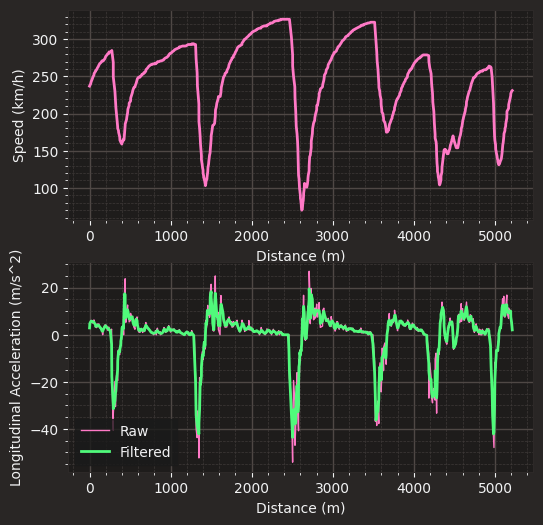

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax, linewidth = 1, label = 'Raw')
axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2, label = 'Filtered')
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")
axes[1].legend()

In [25]:
# I Model: static weight only
m = 798     #kg
g = 9.81

staticWeightTot = m*g

fractionWeightFront = 0.46

staticWeightFront = staticWeightTot * fractionWeightFront
staticWeightRear = staticWeightTot - staticWeightFront

loadFront_staticModel = [staticWeightFront] * len(telemetry_driver['Distance'])
loadRear_staticModel  = [staticWeightRear]  * len(telemetry_driver['Distance'])

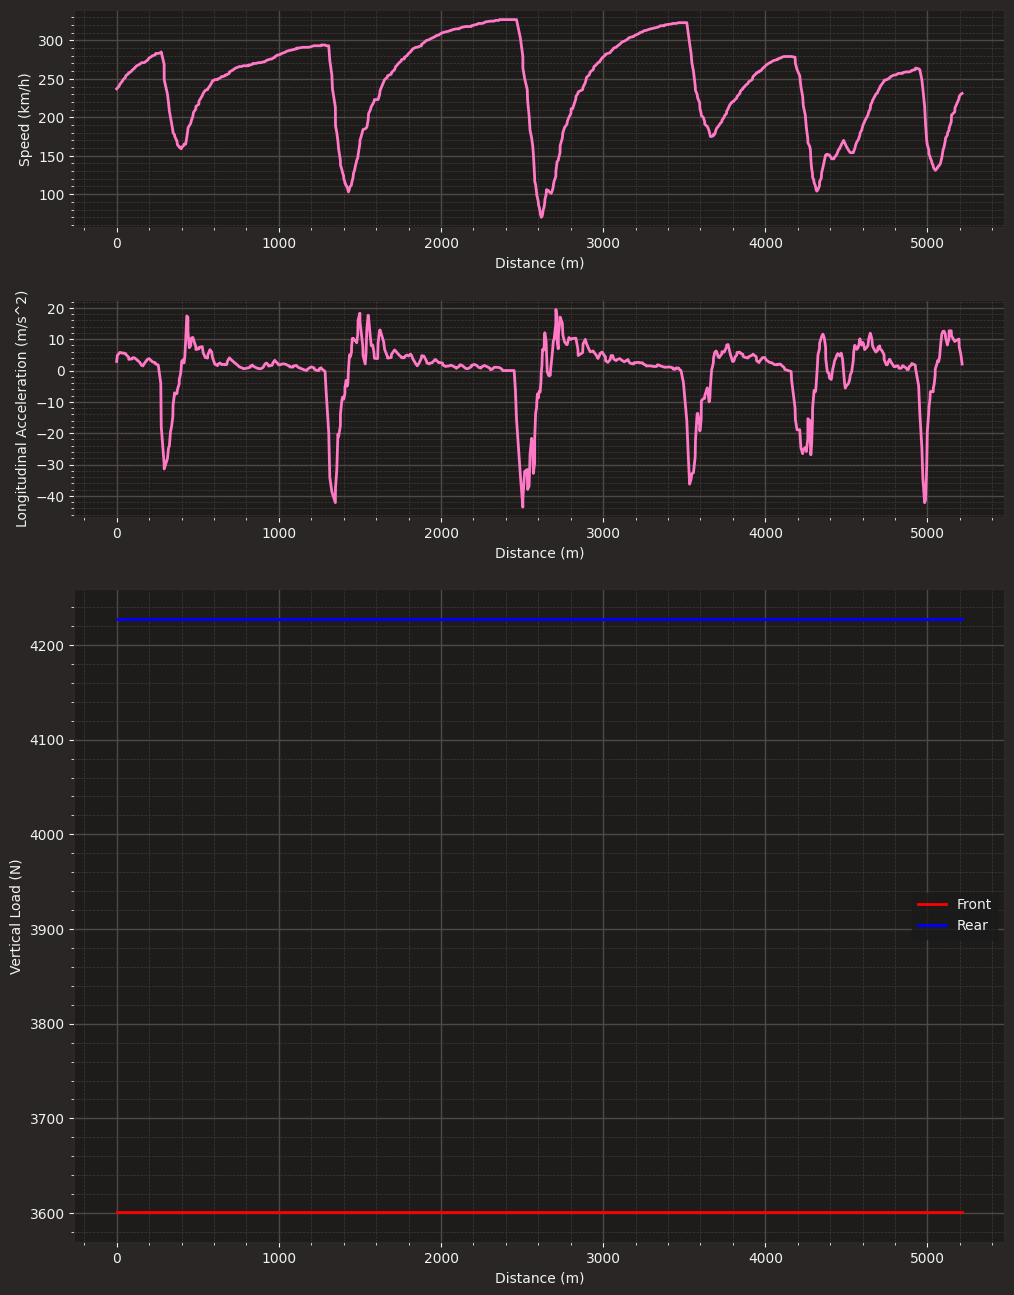

In [26]:
plot_ratios = [1, 1, 3]


fig, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [27]:
# II Model: Inertial load Transfer added
CoGheight = 0.25    # m         # center of gravity
wheelbase = 3.6     # m

deltaLoad = -CoGheight / wheelbase*m*ax_smooth    #Positive Longitudinal Acceleration -> Load shifts to the rear axle (deltaLoad < 0)

loadFront_loadTransferModel = staticWeightFront + deltaLoad
loadRear_loadTransferModel  = staticWeightRear  - deltaLoad

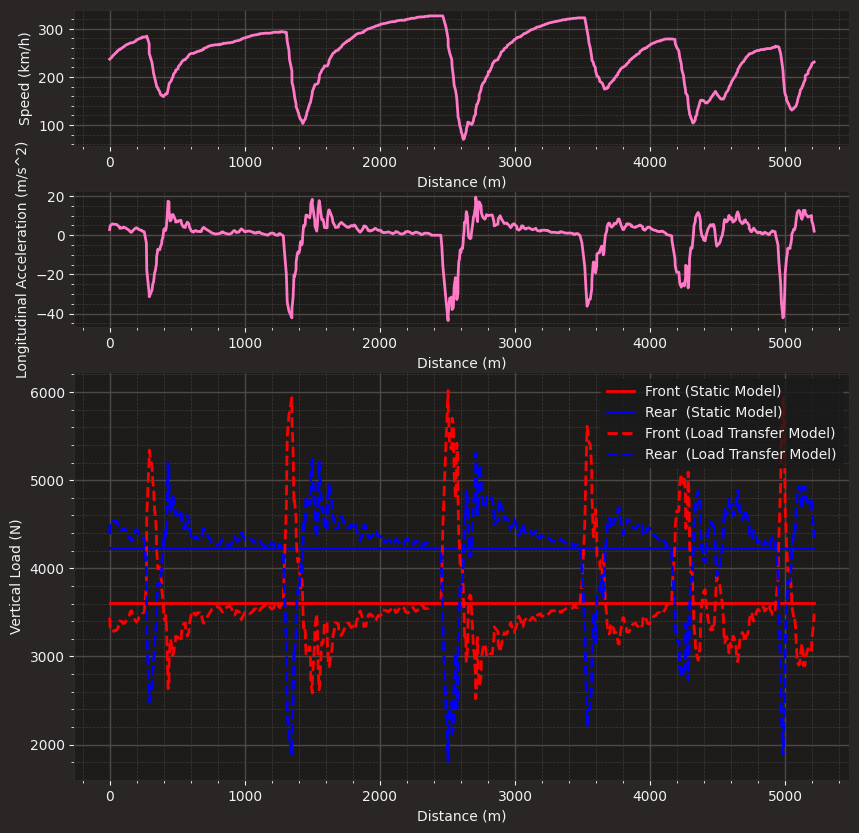

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [30]:
# III Model: the effect of drag and downforce are added

rho = 1.225
CdA = 1.7               # Drag Coefficient * Frontal Area
efficiency = 3.7        # lift/drag
ClA = efficiency*CdA    # Downforce Coefficient * Frontal Area

dragHeight = 0.5 #Height at which the drag force is applied

# We compute the drag and downforce
dragForce = 0.5*CdA*rho*np.square(v)
downForce = 0.5*ClA*rho*np.square(v)

fractionDownforceFront = 0.4    # Front downforce as a fraction of the total downforce (Aero balance)

downForceFront = fractionDownforceFront*downForce
downForceRear = (1 - fractionDownforceFront)*downForce

deltaLoadbyDrag = - dragHeight/wheelbase*dragForce    #Always negative: the drag shifts the load from the front to the rear!

loadFront_loadTransferAeroModel = loadFront_loadTransferModel + downForceFront + deltaLoadbyDrag
loadRear_loadTransferAeroModel  = loadRear_loadTransferModel  + downForceRear  - deltaLoadbyDrag

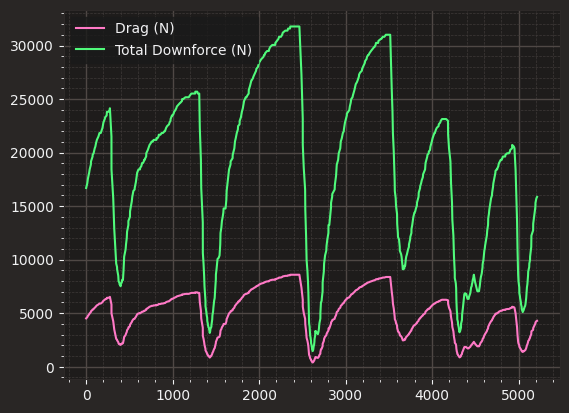

In [31]:
fig, axes = plt.subplots(1)
plt.plot(telemetry_driver['Distance'], dragForce, label = 'Drag (N)')
plt.plot(telemetry_driver['Distance'], downForce, label = 'Total Downforce (N)')
plt.legend()

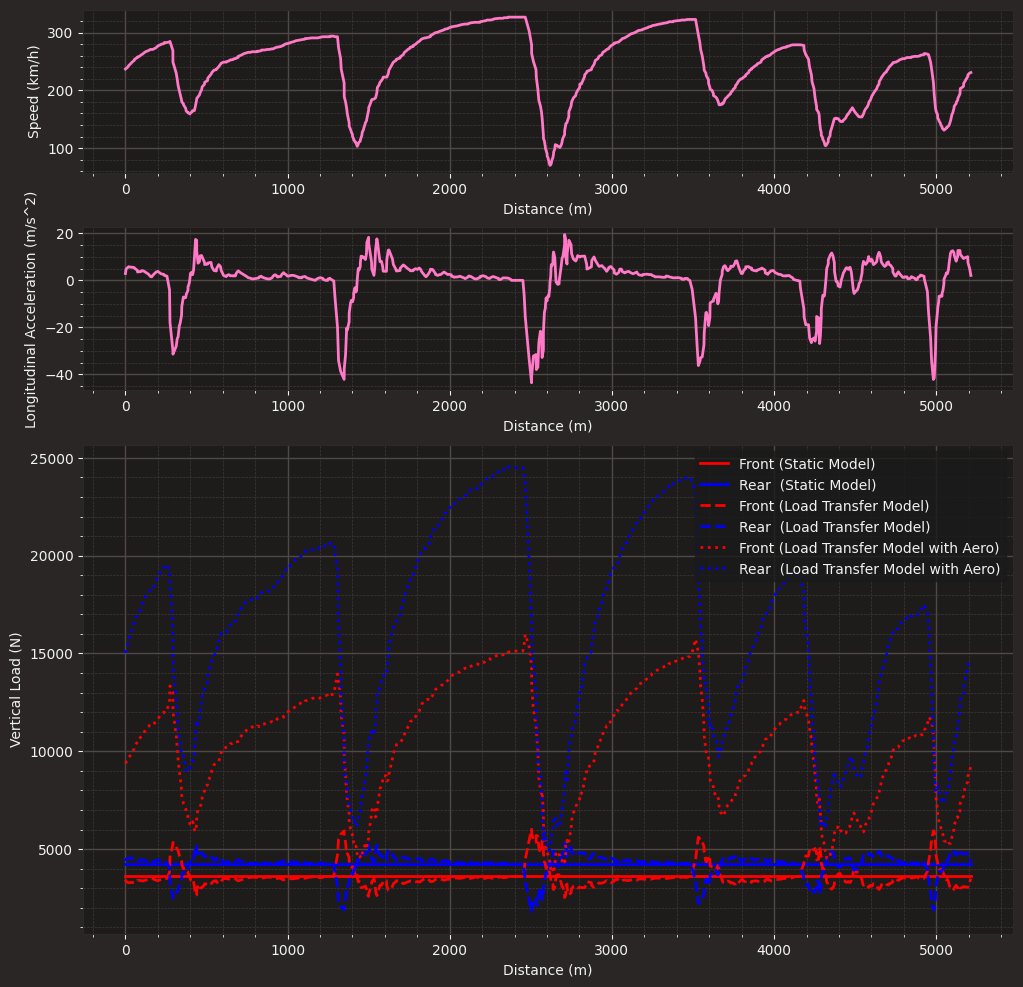

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel, ':r', linewidth = 2, label = 'Front (Load Transfer Model with Aero)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel, ':b',  linewidth = 2, label = 'Rear  (Load Transfer Model with Aero)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()